<a href="https://colab.research.google.com/github/JunaidMovar/ML-DL-Learning/blob/master/SIAMESE_NET_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!yes | pip install -U tensorflow-gpu==2.2 -q

     |████████████████████████████████| 516.2MB 34kB/s 


In [12]:
from tensorflow.keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

In [14]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [15]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17214586745213120267, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9898451212413778588
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18285927416140051815
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11210851648
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8897663223662025581
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
(XTrain,YTrain),(XTest,YTest) = load_data()

170500096/170498071 [==============================] - 5s 0us/step


In [4]:
print(XTrain.shape)
print(YTrain.shape)
print(XTest.shape)
print(YTest.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
Vocab = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

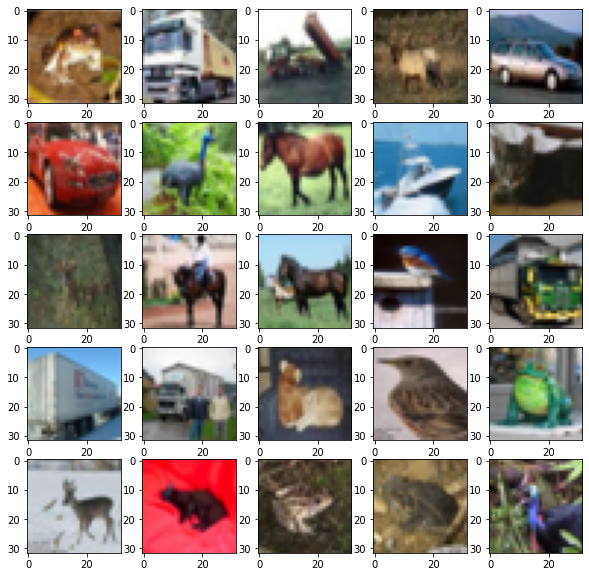

In [6]:
Figure , Sub = plt.subplots(5,5,figsize=(10,10))
count = 0
for _ in range(0,5):
  for __ in range(0,5):
    Sub[_,__].imshow(XTrain[count])
    count += 1
Figure.show()

In [7]:
def DataGenerator(batch,s='train'):
  assert batch % 2 == 0 and batch >= 2,"Batch value Must Be >= 2 and Even Number"
  if s == 'train':
    X,Y = XTrain,YTrain
  else:
    X,Y = XTest,YTest
  
  X1,X2,Similar = [],[],[]
  while batch >= 0:
    rnd1 = np.random.randint(0,len(Y))
    rnd2 = np.random.randint(0,len(Y))
    #Similar Images With X1 and X2 with Similarity of 1
    X1.append(X[rnd1])
    while Vocab[Y[rnd1][0]] != Vocab[Y[rnd2][0]] and rnd1 != rnd2:      
      rnd2 = np.random.randint(0,len(Y))
    X2.append(X[rnd2])
    #print('Similar',Vocab[Y[rnd1][0]], Vocab[Y[rnd2][0]])
    Similar.append(1)
    #Dissimilar Images With X1 and X2 with Similarity of 0
    X1.append(X[rnd1])
    rnd2 = np.random.randint(0,len(Y))
    while Vocab[Y[rnd1][0]] == Vocab[Y[rnd2][0]] and rnd1 != rnd2:
      rnd2 = np.random.randint(0,len(Y))
    X2.append(X[rnd2])
    #print('Dissimilar',Vocab[Y[rnd1][0]], Vocab[Y[rnd2][0]])
    Similar.append(0)
    batch -= 2
  X1 = np.array(X1)
  X2 = np.array(X2)
  Similar = np.array(Similar)
  return X1,X2,Similar

def BatchGenerator(batch,s):
  while True:
    X1,X2 = [],[]
    Y = []
    X1,X2,Y = DataGenerator(batch,s)
    yield [X1,X2],Y

1
0
1
0
1
0


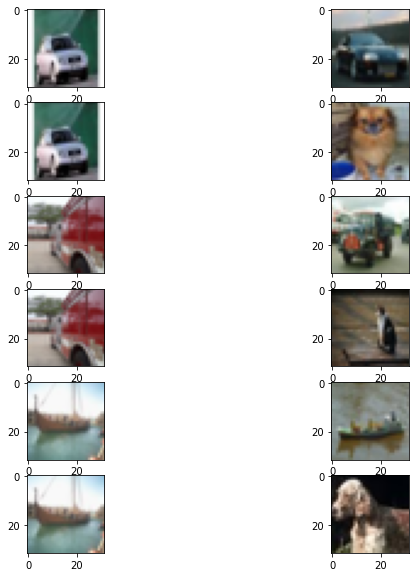

In [8]:
X1,X2,Y0 =DataGenerator(6)
F,S = plt.subplots(6,2,figsize=(10,10),squeeze=False)
cnt = 0
for __ in range(6):
  S[__,0].imshow(X1[cnt])
  S[__,1].imshow(X2[cnt])
  print(Y0[cnt])
  cnt += 1
F.show()

In [30]:
def Show_History():
  plt.plot(History.history['accuracy'])
  plt.title('Accuracy')
  plt.show()
  plt.plot(History.history['val_accuracy'])
  plt.title('Validation Accuracy')
  plt.show()

  plt.plot(History.history['loss'])
  plt.title('Loss')
  plt.show()
  plt.plot(History.history['val_loss'])
  plt.title('Validation Loss')
  plt.show()

In [58]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,GlobalAveragePooling2D,\
                                    BatchNormalization,Dense,Input,Lambda
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

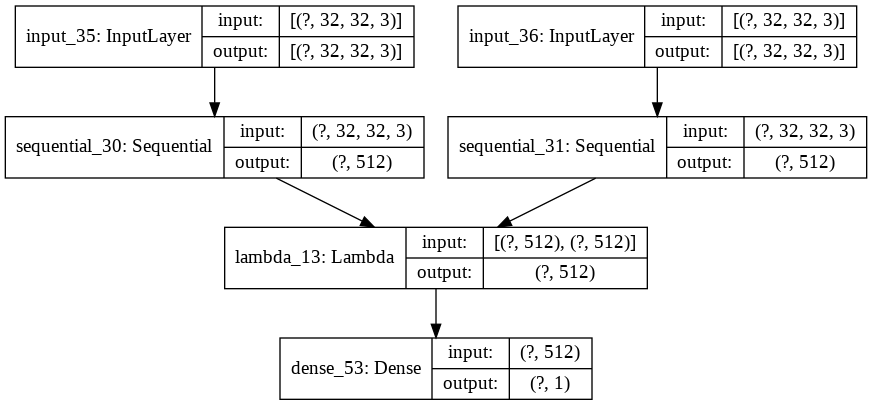

In [59]:
tf.device('/device:GPU:0')
left_inp = Input(shape=(32,32,3))
right_inp = Input(shape=(32,32,3))

def Hands(inp):
  model = Sequential([
          Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal'),
          MaxPool2D((3,3)),

          Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal'),
          MaxPool2D((3,3)),

          GlobalAveragePooling2D(),
          Dense(512,activation='relu',kernel_initializer='he_normal'),
  ])
  return model(inp)
Left = Hands(left_inp)
Right = Hands(right_inp)

lam = Lambda(lambda x: K.abs(x[0]) - K.abs(x[1]))
lam_function = lam([Left,Right])

Pred = Dense(1,activation='sigmoid',kernel_initializer='he_normal')(lam_function)

Siamese = Model(inputs=[left_inp,right_inp],outputs=Pred)

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

Siamese.compile(loss=contrastive_loss,optimizer=Adam(0.0001),metrics=['accuracy'])
#plot_model(model,)
plot_model(Siamese, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [60]:
History = Siamese.fit_generator(BatchGenerator(40,s='train'),\
                                validation_data=BatchGenerator(20,s='a'),\
                                epochs=1000,validation_steps=10,\
                                steps_per_epoch=50,verbose=2)

Epoch 1/1000
50/50 - 1s - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 2/1000
50/50 - 1s - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 3/1000
50/50 - 1s - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 4/1000
50/50 - 1s - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 5/1000
50/50 - 1s - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 6/1000
50/50 - 1s - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 7/1000
50/50 - 1s - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 8/1000
50/50 - 1s - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 9/1000
50/50 - 1s - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 10/1000
50/50 - 1s - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000

KeyboardInterrupt: ignored

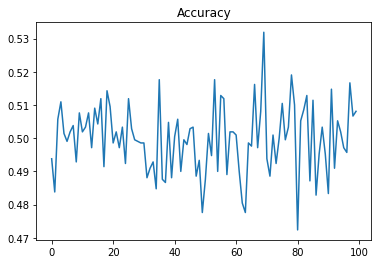

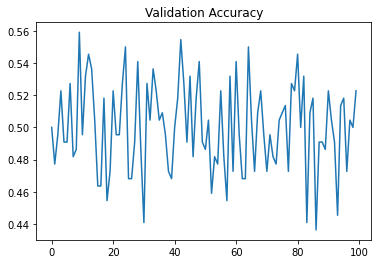

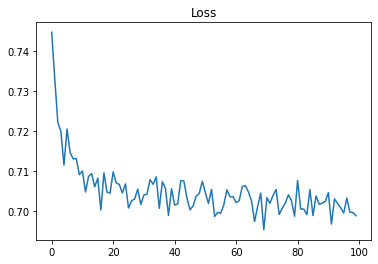

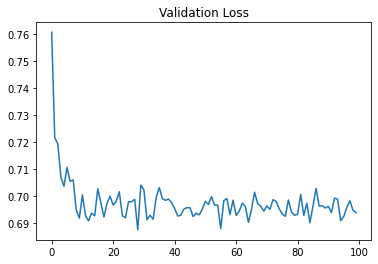

In [45]:
Show_History()